In [82]:
import torch as A
import numpy as np 
import pandas as pd 
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
from matplotlib.image import imread
np.random.seed(42)
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array,array_to_img
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [83]:
# Training transforms.
class TrainTransforms:
    def __init__(self, resize_to):
        self.transforms = A.Compose([
            A.Resize(resize_to, resize_to),
            A.RandomBrightnessContrast(),
            A.RandomFog(),
            A.RandomRain(),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
                ),
            ToTensorV2()
        ])
    
    def __call__(self, img):
        return self.transforms(image=np.array(img))['image']
# Validation transforms.
class ValidTransforms:
    def __init__(self, resize_to):
        self.transforms = A.Compose([
            A.Resize(resize_to, resize_to),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
                ),
            ToTensorV2()
        ])
    
    def __call__(self, img):
        return self.transforms(image=np.array(img))['image']

In [84]:
image_data_list = []
image_labels_list = []
classes = 43
current_path = os.getcwd()

In [85]:
dq = pd.read_csv('C:/Users/hpash/Documents/ML/Project/Dataset/archive/Train.csv',index_col='Width',parse_dates=True)
print('shape of data:',dq.shape)
dq.head()

shape of data: (39209, 7)


,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
Width,,,,,,,
27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [86]:
#dictionary to label all traffic signs class.
classes_dict = { 0:'Speed limit 20km/h',
            1:'Speed limit 30km/h', 
            2:'Speed limit 50km/h', 
            3:'Speed limit 60km/h', 
            4:'Speed limit 70km/h', 
            5:'Speed limit 80km/h', 
            6:'End of speed limit 80km/h', 
            7:'Speed limit 100km/h', 
            8:'Speed limit 120km/h', 
            9:'No passing', 
            10:'No passing vehicles over 3 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'vehicle > 3 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing vehicle > 3 tons' }

In [87]:
data_directory = 'C:/Users/hpash/Documents/ML/Project/Dataset/archive'
train_directory = 'C:/Users/hpash/Documents/ML/Project/Dataset/archive/Train'

# Resizing the images to 30x30x3
image_height = 30
image_width = 30
channels = 3

train_directory_path = os.listdir(train_directory)
categories_num = len(train_directory_path)
categories_num

43

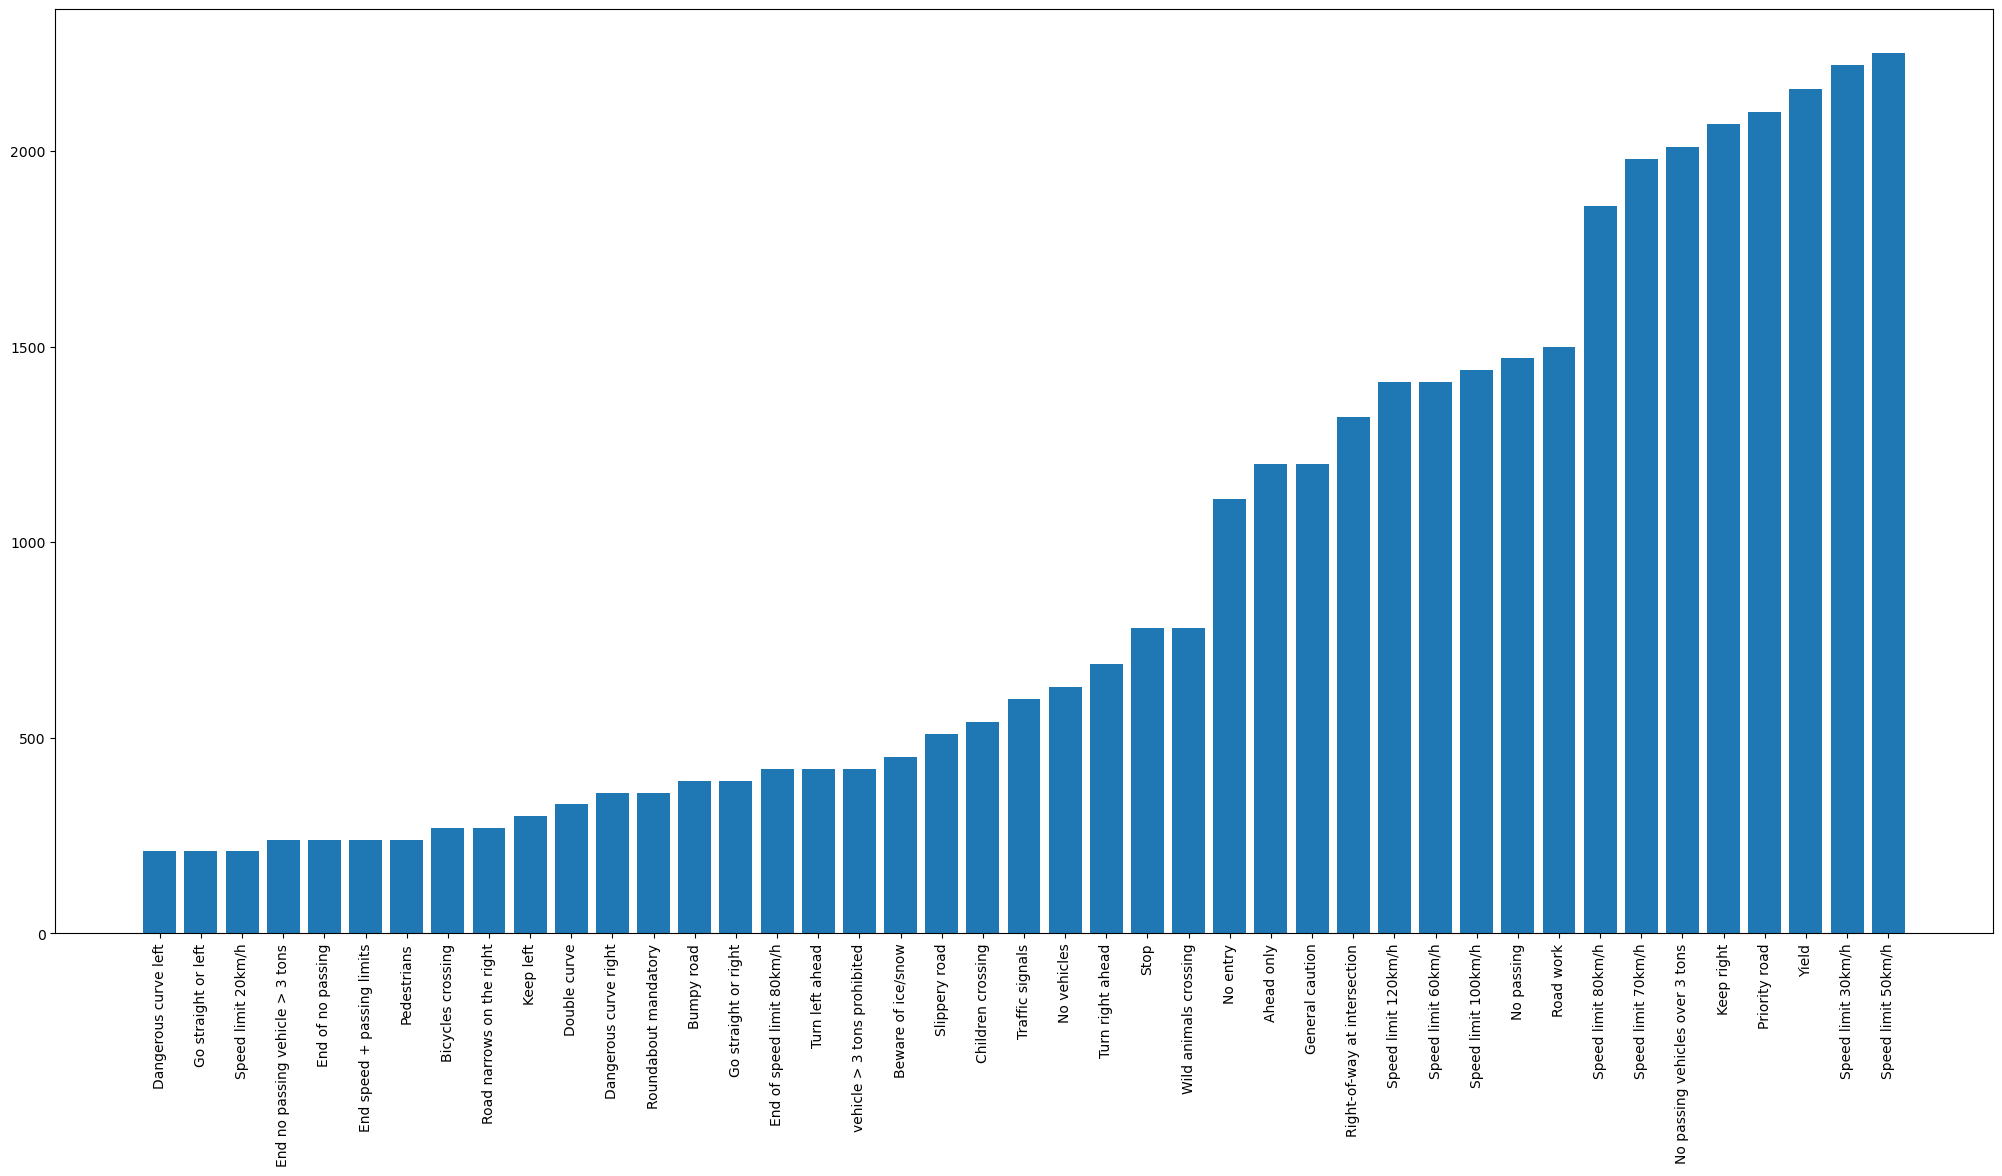

In [88]:
#Visualizing The Dataset

train_list = []
class_list = []

for folder in train_directory_path:
    path = train_directory + '/' + folder
    train_files = os.listdir(path)
    l = len(train_files)
    train_list.append(l)
    cd = classes_dict[int(folder)]
    class_list.append(cd)

tuples = zip(*sorted(zip(train_list, class_list)))
train_list, class_list = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(25,12))  
plt.bar(class_list, train_list)
plt.xticks(class_list, rotation='vertical')
plt.show()

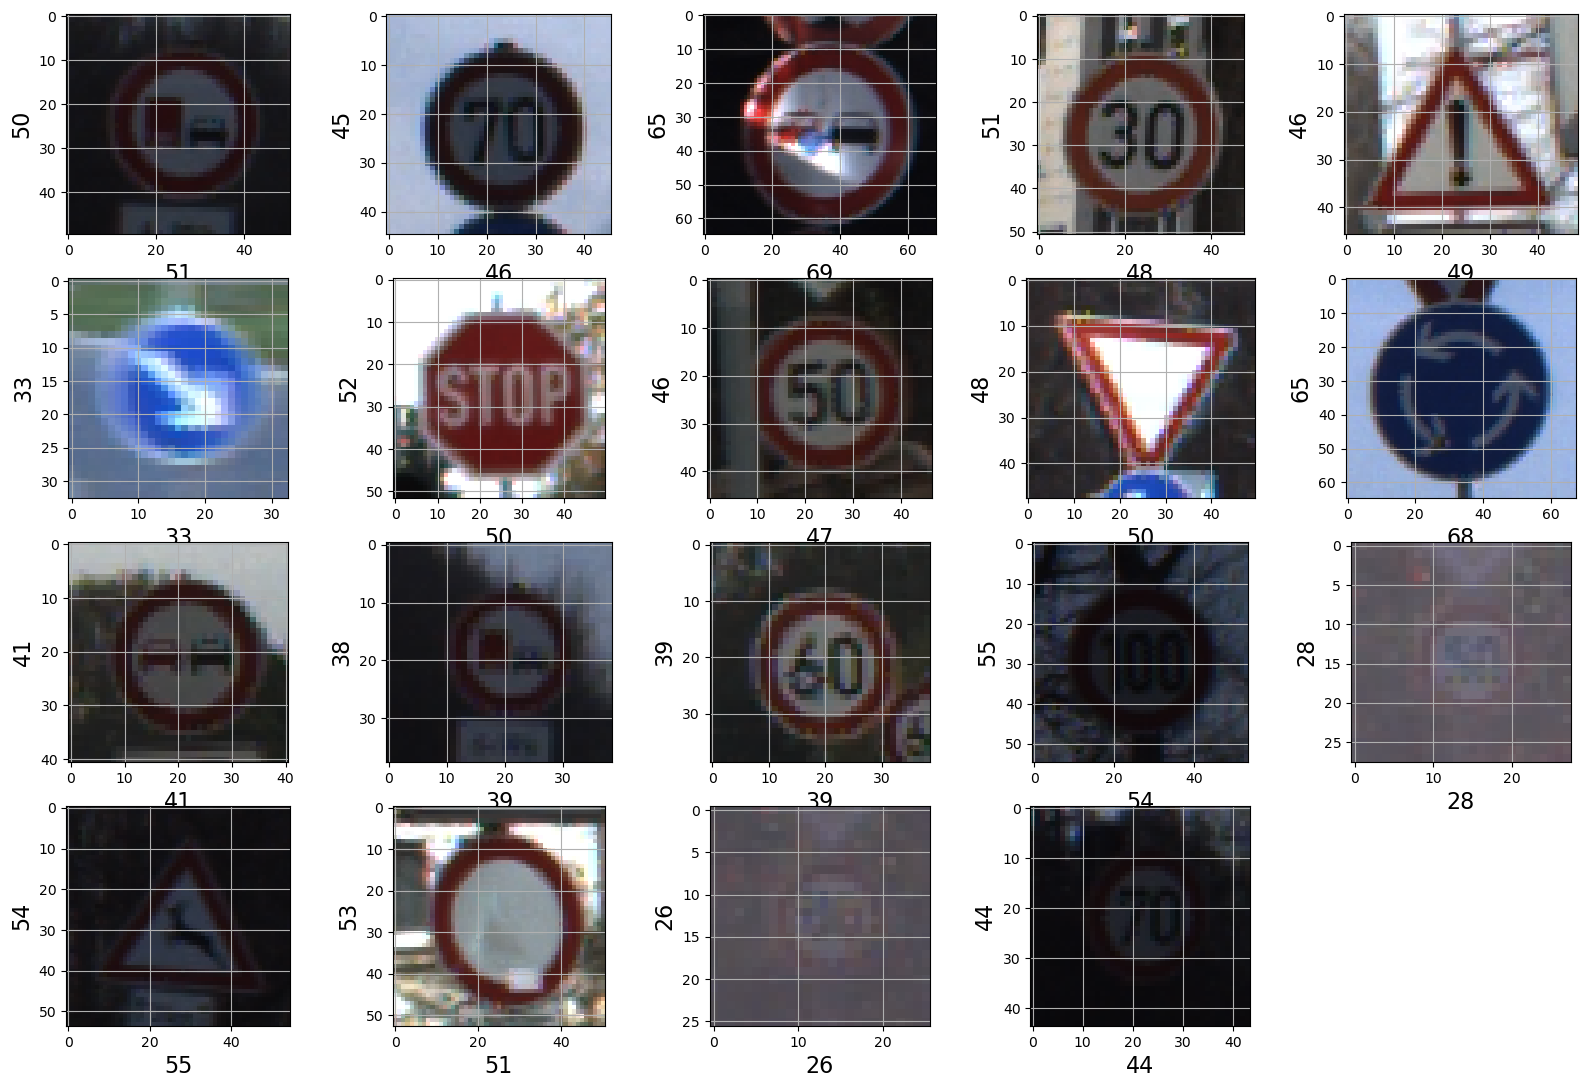

In [89]:
# Visualizing 25 random images from test data

test_directory = pd.read_csv(data_directory + '/Test.csv')
images = test_directory["Path"].values

plt.figure(figsize=(20,20))

for i in range(1,20):
    plt.subplot(6,5,i)
    random_img = imread(data_directory + '/' + random.choice(images))
    plt.imshow(random_img)
    plt.grid()
    plt.xlabel(random_img.shape[1], fontsize = 16)#width of image
    plt.ylabel(random_img.shape[0], fontsize = 16)#height of image

In [90]:
# # Collecting the Training Data

for i in range(categories_num):
    path = data_directory + '/Train/' + str(i)
    images = os.listdir(path)

    for image in images:
        try:
            image = cv2.imread(path + '/' + image)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((image_height, image_width))
            image_data_list.append(np.array(resize_image))
            image_labels_list.append(i)
        except:
            print("Error in " + image)


In [91]:
# # Collecting the Training Data

# for i in range(classes):
#     path = os.path.join(current_path,'train',str(i))
#     images = os.listdir(path)
#     for a in images:
#         try:
#             image = Image.open(path + '\\'+ a)
#             image = image.resize((30,30))
#             image = np.array(image)
#             image_data_list.append(image)
#             image_labels_list.append(i)
#         except:
#             print("Error loading image")

In [92]:
# Changing the list to numpy array

image_data_list = np.array(image_data_list)
image_labels_list = np.array(image_labels_list)

print("Image data list",image_data_list.shape)
print("Image labels list",image_labels_list.shape)

Image data list (39209, 30, 30, 3)
Image labels list (39209,)


In [93]:
# Shuffling the training data

shuffle_indexes = np.arange(image_data_list.shape[0])
np.random.shuffle(shuffle_indexes)
image_data_list = image_data_list[shuffle_indexes]
image_labels_list = image_labels_list[shuffle_indexes]


In [98]:
# Splitting the data into train and validation set

X_train, X_valid, y_train, y_valid = train_test_split(image_data_list, image_labels_list, test_size=0.2, random_state=42, shuffle=True)

X_train = X_train/225 
X_valid = X_valid/225
y_train = y_train/225 
y_valid = y_valid/225

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_valid.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_valid.shape)

# # One hot encoding the labels

y_train = to_categorical(y_train, 43)
y_valid = to_categorical(y_valid, 43)

print(y_train.shape,y_test.shape)

X_train.shape (31367, 30, 30, 3)
X_valid.shape (7842, 30, 30, 3)
y_train.shape (31367,)
y_valid.shape (7842,)
(31367, 43) (7842, 43, 43)


In [95]:
# Splitting the data into train and test set

# X_train, X_test, y_train, y_test = train_test_split(image_data_list, image_labels_list, test_size=0.2, random_state=42)

# X_train = X_train/225.0
# X_test = X_test/225.0
# y_train = y_train/225.0
# y_test = y_test/225.0
# X_train = X_train.reshape( -1,30,30,3)
# X_test = X_test.reshape( -1,30,30,3)

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

# # One hot encoding the labels

# y_train = to_categorical(y_train, 43)
# y_test = to_categorical(y_test, 43)

# print(y_train.shape,y_test.shape)

(31367, 43) (7842, 43, 43)


In [100]:
# Label binarizing
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_valid = lb.fit_transform(y_valid)
print(lb.classes_)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


In [101]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [102]:
# Building the model

# model = Sequential()
# # model.add(keras.Input(shape=(30, 30, 3)))

# # model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
# model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(30,30,3)))
# model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(BatchNormalization(axis=-1))
# # model.add(Dropout(rate=0.25))
# model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
# model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(BatchNormalization(axis=-1))
# # model.add(Dropout(rate=0.25))
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# # model.add(BatchNormalization)
# model.add(Dropout(rate=0.5))
# # model.add(layers.Dense(64, kernel_initializer='uniform', input_shape=(10,)))
# model.add(Dense(43, activation='softmax'))
# model.add(layers.Activation('softmax'))

In [121]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(image_height,image_width,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [122]:
learning_rate = 0.001
epochs = 2
# optimizers = tf.keras.optimizers.Adam()

optimizers = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=optimizers, metrics=['accuracy'])

In [145]:
# Augmenting the data and training the model

augmentation = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=None,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    fill_mode="nearest")

In [146]:
# history = model.fit(augmentation.flow(X_train, y_train, batch_size=64), 
#                     steps_per_epoch=len(X_train) / 64, epochs=epochs, validation_data=(X_test, y_test))

# history = model.fit(augmentation.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_test, y_test))

history = model.fit(augmentation.flow(X_train, y_train, batch_size=32), 
                    steps_per_epoch=len(X_train) / 32, epochs=epochs, validation_data=(X_valid, y_valid))


Epoch 1/2
980/980 [==============================] - 76s 77ms/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 4.2708e-05 - val_accuracy: 1.0000
Epoch 2/2
980/980 [==============================] - 105s 107ms/step - loss: 7.6377e-04 - accuracy: 0.9999 - val_loss: 4.2347e-05 - val_accuracy: 1.0000


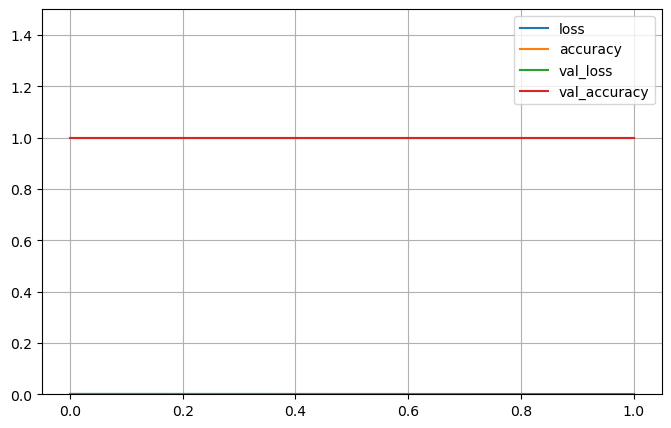

In [147]:
# Evaluating the model

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()

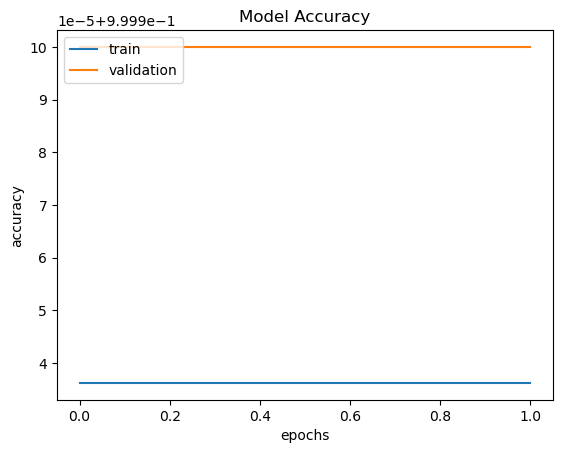

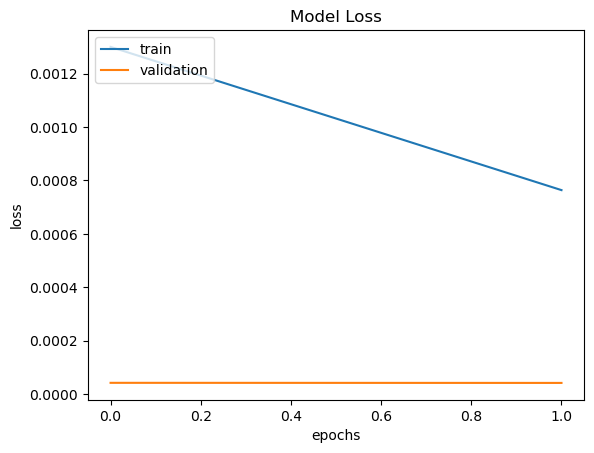

In [148]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [149]:
test_path = data_directory + '/Test.csv'
test_directory = pd.read_csv(test_path)
# images = test_directory["Path"].values
# test = pd.read_csv(data_directory + '/Test.csv')

labels_path = test_directory["ClassId"].values
images_path = test_directory["Path"].values

data_list =[]

In [150]:
# Loading the test data and running the predictions

for img in images_path:
    try:
        image = cv2.imread(data_directory + '/' + img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((image_height, image_width))
        data_list.append(np.array(resize_image))
#         data_list.append(i)
    except:
        print("Error in " + image)


In [151]:
from sklearn.metrics import accuracy_score
X_test = np.array(data_list)
X_test = X_test/225

prediction = np.argmax(model.predict(X_test), axis=-1)
# prediction = np.argmax(model.predict(X_test))

395/395 [==============================] - 8s 19ms/step


In [152]:
# Storing predictions
# Plotting image to compare
img = array_to_img(X_test[2])
img

In [153]:
# Finding max value from prediction list and comparing original value vs predicted
labels = lb.classes_
print(labels)
print("Originally : ",labels[np.argmax(y_test[2])])
print("Predicted : ",labels[np.argmax(prediction[2])])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
Originally :  1
Predicted :  0


In [160]:
#Accuracy with the test data

print('Test Data accuracy: ',accuracy_score(labels_path, prediction)*100)

Test Data accuracy:  0.4750593824228029


In [155]:
#Visualizing the confusion matrix

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(labels_path, prediction)

<AxesSubplot:>

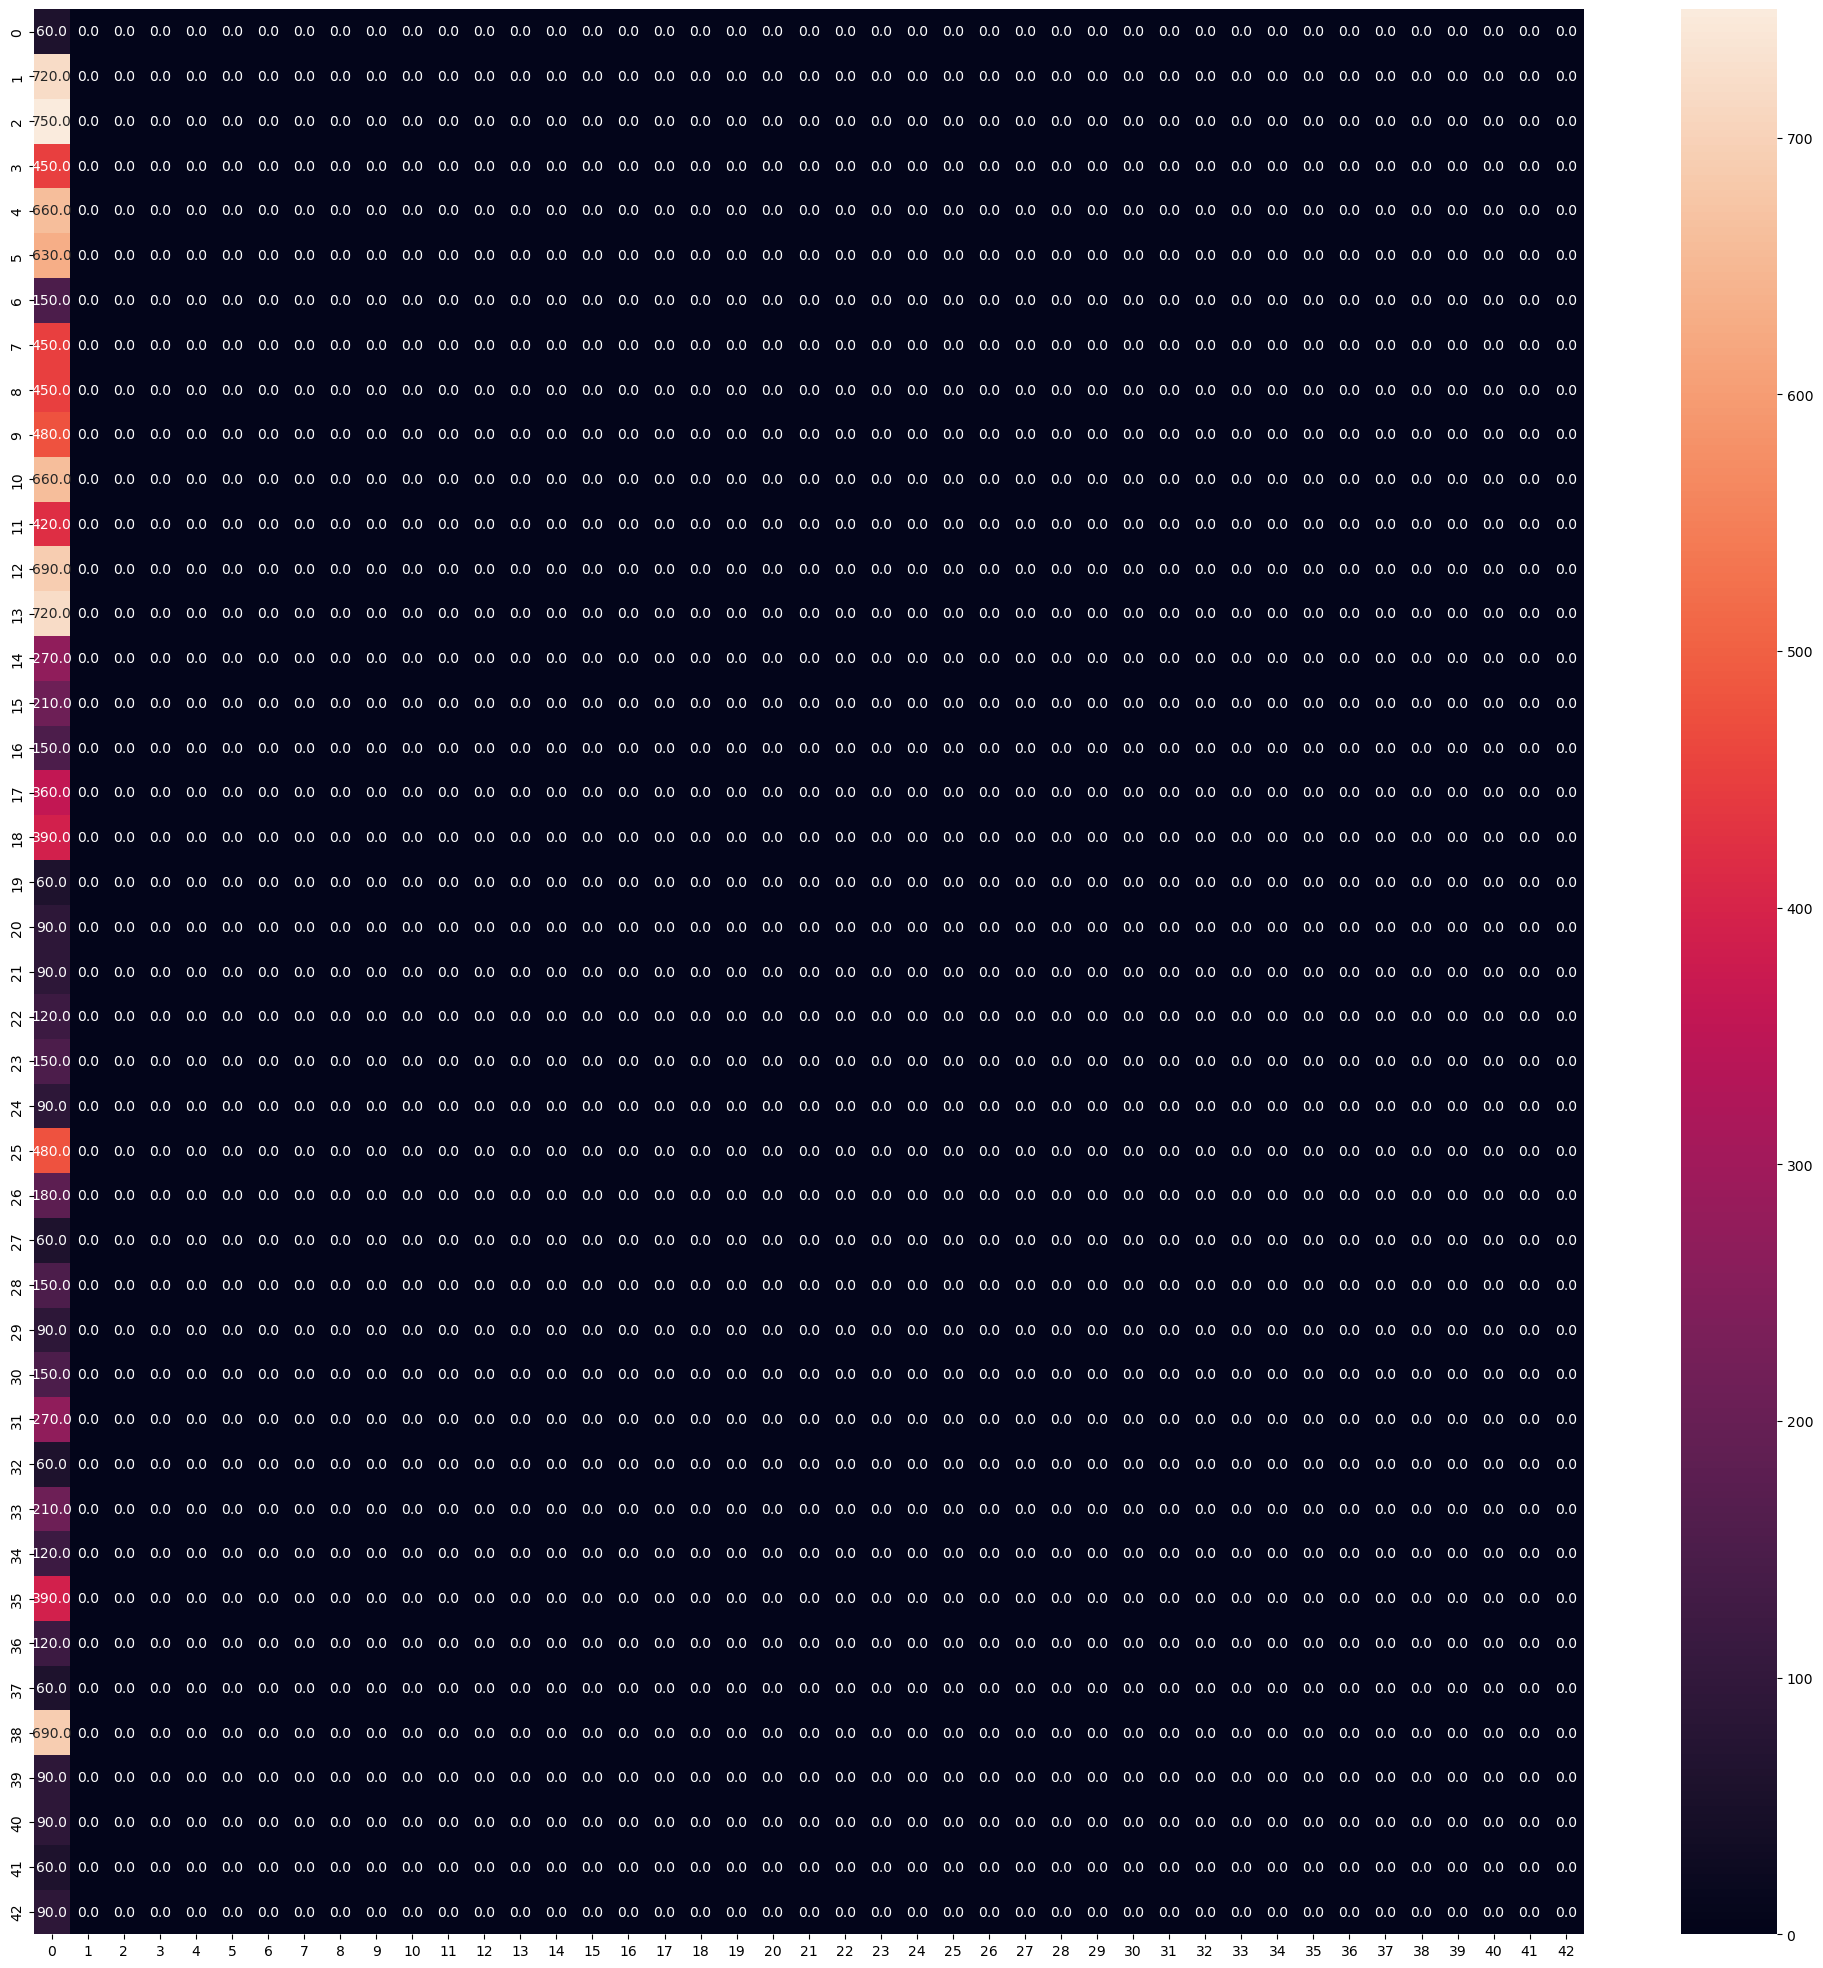

In [156]:
import seaborn as sns
df_cm = pd.DataFrame(conf_matrix, index = classes_dict,  columns = classes_dict)
plt.figure(figsize = (25,25))
sns.heatmap(df_cm, annot=True, fmt=".1f")

In [157]:
#Classification report

from sklearn.metrics import classification_report

print(classification_report(labels_path, prediction))

              precision    recall  f1-score   support

           0       0.00      1.00      0.01        60
           1       0.00      0.00      0.00       720
           2       0.00      0.00      0.00       750
           3       0.00      0.00      0.00       450
           4       0.00      0.00      0.00       660
           5       0.00      0.00      0.00       630
           6       0.00      0.00      0.00       150
           7       0.00      0.00      0.00       450
           8       0.00      0.00      0.00       450
           9       0.00      0.00      0.00       480
          10       0.00      0.00      0.00       660
          11       0.00      0.00      0.00       420
          12       0.00      0.00      0.00       690
          13       0.00      0.00      0.00       720
          14       0.00      0.00      0.00       270
          15       0.00      0.00      0.00       210
          16       0.00      0.00      0.00       150
          17       0.00    

C:\Users\hpash\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hpash\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hpash\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


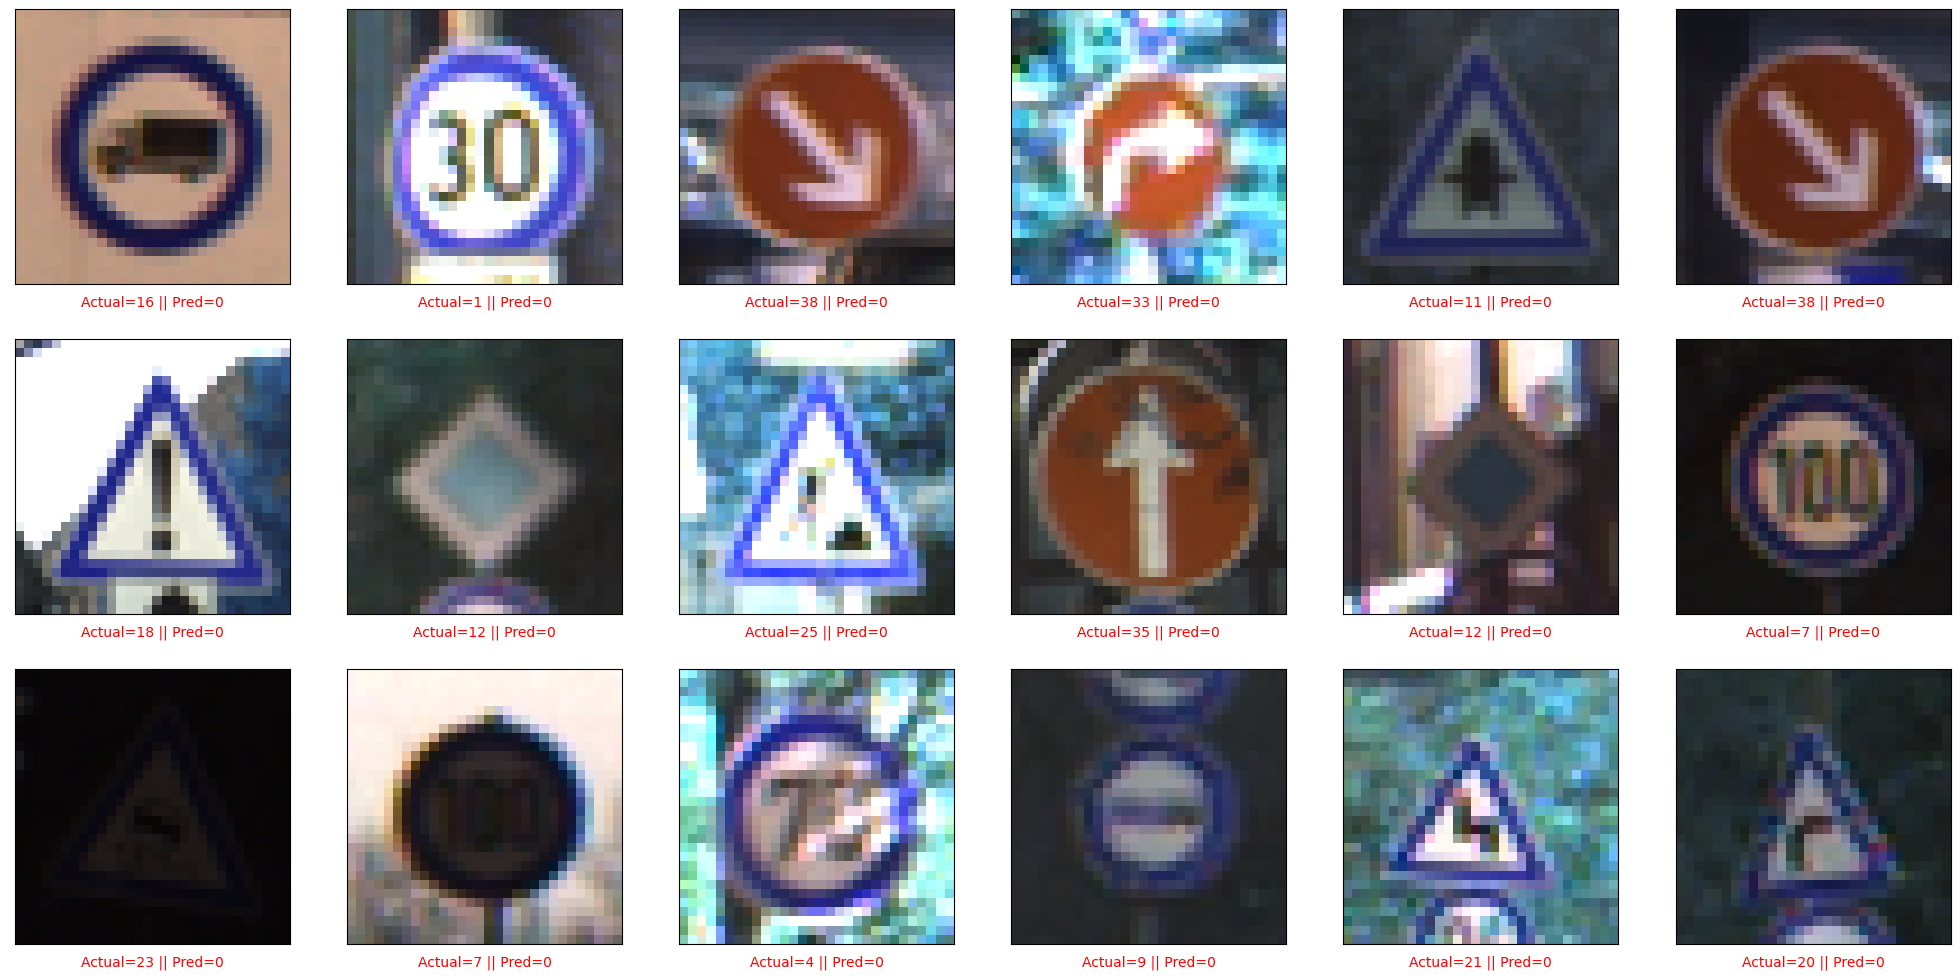

In [158]:
# Predictions on Test Data

plt.figure(figsize = (25, 25))

start_index = 0
for i in range(18):
    plt.subplot(6, 6, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    predictions = prediction[start_index + i]
    actual = labels_path[start_index + i]
    clr = 'g'
    if predictions != actual:
        clr = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, predictions), color = clr)
    plt.imshow(X_test[start_index + i])
plt.show()

In [159]:
model.save("traffic_classifier.h5py")

INFO:tensorflow:Assets written to: traffic_classifier.h5py\assets


INFO:tensorflow:Assets written to: traffic_classifier.h5py\assets
